# 微调
一个神经网络一般分为两块
* 特征抽取将原始像素变成容易线性分割的特征
* 线性分类器来做分类

<img src='./image/structure.jpg' alt="structure" width=400 ><br>

## 微调架构
<img src='./image/fineTune.jpg' alt="fineTune" width=400 ><br>
微调中的权重初始化<br>
<img src='./image/fineTuneW.jpg' alt="fineTuneWeight" width=400 ><br>

## 训练
是一个目标数据集上的正常训练任务，但是用更强的正则化
* 使用更小的学习率
* 使用更少的数据迭代

原数据即远复杂于目标数据，通常微调效果更好<br>

固定一些层<br>
神经网路通常学习有层次的特征表示
* 低层次的特征更加通用
* 高层次的特征则更跟数据集相关
* 可以固定底部一些层的参数，不参与更新
* 更强的正则

In [1]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

# 热狗数据集来源于网络
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                          'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

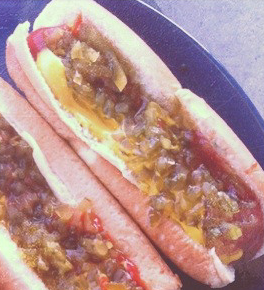

In [7]:
train_imgs[2][0] # 图片+标签

数据增广

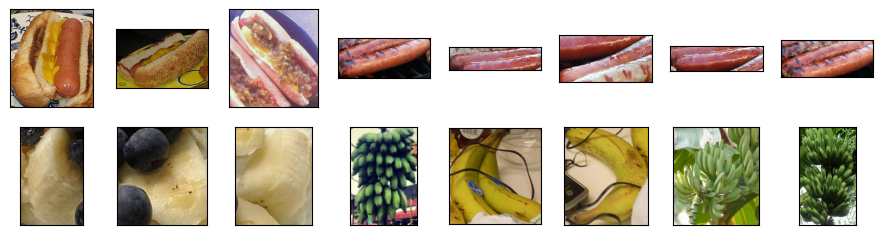

In [8]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [18]:
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])
# 对均值和方差做Normlize，因为imageNet里面做了所以这里也要做

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(), normalize]) # 如果网络里有BN层则不需要？

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224), # 因为图片的高宽比都不一样
    torchvision.transforms.ToTensor(), normalize])

定义和初始化模型

In [12]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

pretrained_net.fc

c:\Users\jeff\.conda\envs\env_for_d2l\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jeff\.conda\envs\env_for_d2l\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=512, out_features=1000, bias=True)

In [13]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2) # 随机初始化成为一个输入相同，输出改为2，因为是一个二分类问题
nn.init.xavier_uniform_(finetune_net.fc.weight) # 对最后一层随机初始化

Parameter containing:
tensor([[ 0.0773, -0.1075, -0.0754,  ...,  0.1034,  0.0813,  0.0288],
        [-0.0562, -0.0934, -0.0276,  ...,  0.0347,  0.0392,  0.0417]],
       requires_grad=True)

微调模型

In [15]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                         transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'),
                                         transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus() # 多gpu
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group: # 如果为true，将前面的层和后面的层的学习率分别设置
        params_1x = [
            param for name, param in net.named_parameters()
            if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{
            'params': params_1x}, {
                'params': net.fc.parameters(),
                'lr': learning_rate * 10}], lr=learning_rate,
                                  weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

使用较小的学习率


loss 0.255, train acc 0.921, test acc 0.922
390.4 examples/sec on [device(type='cuda', index=0)]


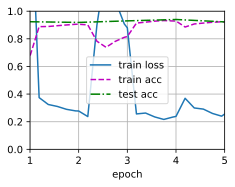

In [16]:
train_fine_tuning(finetune_net, 5e-5) # 最后一层随机，其余全部是原权重

为了进行比较， 所有模型参数初始化为随机值<br>
可以看到准确率有一定差距

loss 0.337, train acc 0.850, test acc 0.848
422.5 examples/sec on [device(type='cuda', index=0)]


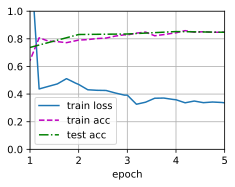

In [17]:
scratch_net = torchvision.models.resnet18() # 不设置pretrain
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)